In [27]:
def generate_xyz_trajectory(
    x0, y0, z0,
    vx0, vy0, vz0,
    ax0, ay0, az0,
    num_points, dt
):
    '''
    Simulate constant acceleration trajectory.
    Add noise to the output to simulate measurements.
    '''
    x, y, z = [x0], [y0], [z0]

    # Generate raw points
    for n in range(1, num_points):
        t = n * dt

        x.append( x0 + vx0*t + ax0*(t**2)/2 )
        y.append( y0 + vy0*t + ay0*(t**2)/2 )
        z.append( z0 + vz0*t + az0*(t**2)/2 )

    return x, y, z

import numpy as np
def add_noise(
    a, b, c,
    stds, mean=0
    ):
    '''
    Add gausian noise with a specified mean and variance to coordinates a, b, c to simulate
    noisy measurements

    Args:
        a b c (np.ndarray): input arrays
        stds (list[float]): 3 variances for a, b, c respectifully
        mean (float): mean for all 3 noises added
    '''
    
    sz = len(a)
    gaussian_noise = np.random.default_rng().normal(loc=mean, scale=stds[0], size=sz)
    a_n = a + gaussian_noise
    gaussian_noise = np.random.default_rng().normal(loc=mean, scale=stds[1], size=sz)
    b_n = b + gaussian_noise
    gaussian_noise = np.random.default_rng().normal(loc=mean, scale=stds[2], size=sz)
    c_n = c + gaussian_noise

    return a_n, b_n, c_n

import matplotlib.pyplot as plt
def plot_trajectory_1d(timestamps, data, coord_name=''):
    if (len(timestamps) != len(data)):
        print('plot_trajectory_1d(): '\
              f'expected matching input lengths, got {len(timestamps)}, {len(data)} instead.')
        return None

    fig, ax = plt.subplots(nrows=1, ncols=1)

    ax.plot(timestamps, data)
    ax.set_xlabel('Время')
    ax.set_ylabel(f'Координата {coord_name}')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()

def plot_trajectory_3d(x, y, z, title=''):
    ax = plt.figure().add_subplot(projection='3d')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.plot(x, y, z)
    ax.set_title(title)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()

def plot_filtering_results_1d(x_pred, z, timestamps):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))

    ax.plot(timestamps, x_pred, color='r', label='Предсказания фильтра')
    ax.scatter(timestamps, z, color='k', alpha=0.8, marker='.', s=8, label='Измерения')
    ax.set_xlabel('Время')
    ax.set_ylabel('Координата')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    fig.legend()
    plt.show()
    
def plot_residues_1d(y, sigmas, timestamps, scale=1):
    '''
    Plot residues to visually evaluate perfomance of a Kalman filter.
    y is expected to be calculated as z - H@x
    Args:
        y: residues.
        sigmas: variances taken from the filter's matrix P.
        timestamps: timeline.
        scale: draw +-scale*sigmas lines to see if the residue falls between them,
    '''
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4))

    ax.plot(timestamps, y, label='Невязка')
    ax.plot(timestamps, scale*sigmas, linestyle='--', color='k', label=f'{scale}'+r'$\sigma$')
    ax.plot(timestamps, -scale*sigmas, linestyle='--', color='k')
    ax.fill_between(timestamps, scale*sigmas, -scale*sigmas, color='y')

    ax.grid(True, which='both', axis='y', color='gray', linestyle='--', linewidth=0.7)
    ax.set_xlabel('Время')
    ax.set_ylabel('Невязка')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    fig.legend()
    plt.show()

import numpy as np
def xyz_to_sphere(X: list, Y:list , Z:list) -> tuple[list, list, list]:
    '''
    Convert x y z coordinates to spherical r u v

    NOTE: 
    - r is defined as sqrt(x^2 + y^2 + z^2)
    - u is defined as sin(phi_u) where phi_u is the polar angle
    - v is defined as sin(phi_v) where phi_v is the azimuth angle
    '''
    R, U, V = [], [], []
    for x, y, z in zip(X, Y, Z):
        r = np.sqrt(x**2 + y**2 + z**2)
        R.append( r )
        # u.append( np.arctan2(y, x) )
        U.append( z / r )
        # v.append( np.arctan2(z, np.sqrt(x**2 + y**2)) )
        V.append( y / np.sqrt( x**2 + y**2) )

    return R, U, V

def sphere_to_xyz(R, U, V):
    x, y, z = [], [], []
    for r, u, v in zip(R, U, V):
        x.append( r*np.cos(v)*np.cos(u) )
        y.append( r*np.cos(v)*np.sin(u) )
        z.append( r*np.sin(v) )
 
    return x, y, z

In [28]:
import numpy as np
class KalmanFilter():
    def __init__(self, dim_x, dim_z, dim_u,
                 x0,
                 P, H, F, B, Q, R):
        self.dim_x = dim_x
        self.dim_z = dim_z
        self.dim_u = dim_u

        self.x = np.asarray(x0)[:, np.newaxis]
        self.u = np.zeros(dim_u)[:, np.newaxis]

        self.P = np.asarray(P)
        self.H = np.asarray(H)
        self.F = np.asarray(F)
        self.B = np.asarray(B)
        self.Q = np.asarray(Q)
        self.R = np.asarray(R)
    
    def predict(self, x=None, P=None, F=None, Q=None, u=None, B=None):
        # some god awful way to handle external calls here
        # maybe just avoid having all of these as parameters
        # so when you want to use external matrices, you just need to make a new filter
        # bruh

        if x is None:
            x = self.x
        if P is None:
            P = self.P
        if F is None:
            F = self.F
        if Q is None:
            Q = self.Q
        if u is None:
            u = self.u
        if B is None:
            B = self.B

        x_pred = F@x #+ B@u
        P_pred = F@P@F.T + Q

        return x_pred, P_pred

    def update(self, x, P, H, z, R):
        if (z.size > 1):
            z = z[:, np.newaxis]

        S = H@P@H.T + R
        # S_inv = np.linalg.pinv(S) 
        S_inv = np.linalg.inv(S)
        K = P@H.T@S_inv

        y = z - H@x
        x_est = x + K@y
        I = np.eye(N=self.dim_x)
        P_est = (I - K@H)@P@(I - K@H).T + K@R@K.T

        return x_est, P_est
    
    def batch_filter(self, Z):
        '''
        Perform batch filtering on measurements Z.

        Returns a numpy array with the shape of (len(Z), len(x)), so the estimations
        are stored as rows! And each row corresponds to a measurement (timepoint).
        '''

        old_x = self.x
        old_P = self.P

        Z = np.asarray(Z)
        X = []

        for z in Z:
            self.x, self.P = self.predict(self.x, self.P, self.F, self.Q)
            self.x, self.P = self.update(self.x, self.P, self.H, z, self.R)

            X.append(self.x)
         
        self.x = old_x
        self.P = old_P
        return np.squeeze(np.asarray(X))
    
    def evaluate_perfomace(self, Z):
        Z = np.asarray(Z)
        Ps = []
        Y = []

        for z in Z:
            self.x, self.P = self.predict(self.x, self.P, self.F, self.Q)
            Ps.append(self.P)

            #if (z.size > 1):
            #    z = z[:, np.newaxis]
            y = z[:, np.newaxis] - self.H@self.x
            Y.append(y)

            self.x, self.P = self.update(self.x, self.P, self.H, z, self.R)

        return np.squeeze(np.asarray(Y)), np.asarray(Ps)

from scipy.linalg import block_diag
def Q_discrete_white_noise(dim, dt=.1, var=1., block_size=1):
    '''
    Ordering will be [x x' x'' y y' y''].
    '''
    if dim not in [2, 3, 4]:
        raise ValueError("dim must be between 2 and 4")

    if dim == 2:
        Q = [[.25*dt**4, .5*dt**3],
             [ .5*dt**3,    dt**2]]
    elif dim == 3:
        Q = [[.25*dt**4, .5*dt**3, .5*dt**2],
             [ .5*dt**3,    dt**2,       dt],
             [ .5*dt**2,       dt,        1]]
    else:
        Q = [[(dt**6)/36, (dt**5)/12, (dt**4)/6, (dt**3)/6],
             [(dt**5)/12, (dt**4)/4,  (dt**3)/2, (dt**2)/2],
             [(dt**4)/6,  (dt**3)/2,   dt**2,     dt],
             [(dt**3)/6,  (dt**2)/2 ,  dt,        1.]]

    
    return block_diag(*[Q]*block_size) * var

# Генерация траектории

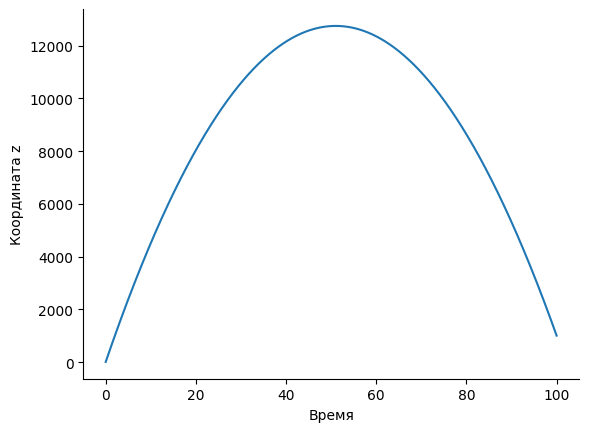

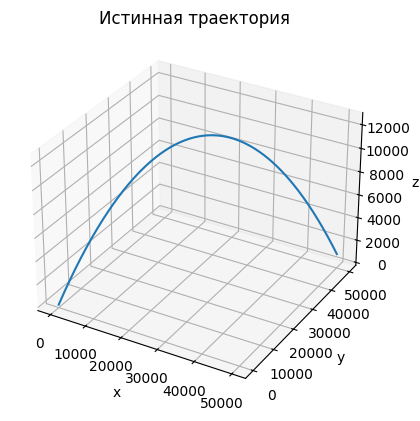

In [33]:
import numpy as np
x, y, z = generate_xyz_trajectory(
    10, 10, 10,
    500, 500, 500,
    0, 0, -9.81,
    1000, 0.1)

t = np.linspace(0, 1000*0.1, 1000)
plot_trajectory_1d(t, z, coord_name='z')
plot_trajectory_3d(x, y, z, title='Истинная траектория')

In [34]:
r, u, v = xyz_to_sphere(x, y, z)
r_n, u_n, v_n = add_noise(r, u, v, stds=[50, 0.01, 0.01])

In [31]:
# x_n, y_n, z_n = sphere_to_xyz(r, u, v)
# x_n, y_n, z_n = add_noise(x, y, z, stds=[250, 250, 250])
# plot_trajectory_3d(x_n, y_n, z_n, title='Измерения')

# Пробная фильтрация каждой координаты отдельно

In [ ]:
dt = 0.1

x0=np.array([10., 500.])

P = np.array([
    [250., 0],
    [0, 100.]
])
H = np.array([
    [1., 0],
])
F = np.array([
    [1., dt],
    [0, 1.]
])
B = np.array([[0]])
Q = np.array([[0.588, 1.175],
              [1.175, 2.35 ]])
R = np.array([
[25,]
])

kf = KalmanFilter(
    dim_x=2,
    dim_z=1,
    dim_u=0,
    x0=x0,
    P=P, H=H, F=F, B=B, Q=Q, R=R
)

In [141]:
dt = 0.1
x0=np.array([10., 500.])
P = np.array([
    [250., 0],
    [0, 100.]
])
H = np.array([
    [1., 0],
])
F = np.array([
    [1., dt],
    [0, 1.]
])
B = np.array([[0]])
Q = np.array([[0.588, 1.175],
              [1.175, 2.35 ]])
R = np.array([
[25,]
])

kf = KalmanFilter(
    dim_x=2,
    dim_z=1,
    dim_u=0,
    x0=x0,
    P=P, H=H, F=F, B=B, Q=Q, R=R
)

In [142]:
x_out = kf.batch_filter(x_n)
y_out = kf.batch_filter(y_n)
z_out = kf.batch_filter(z_n) 

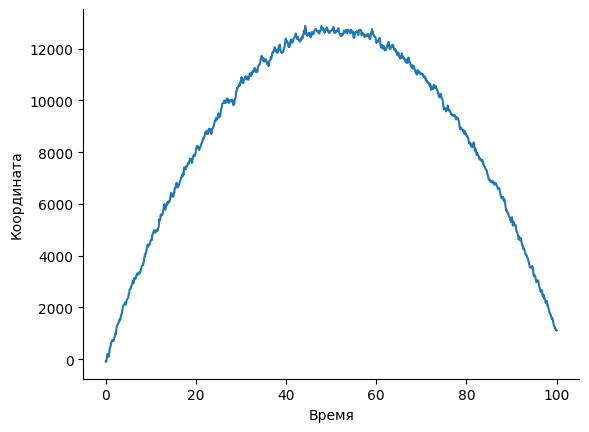

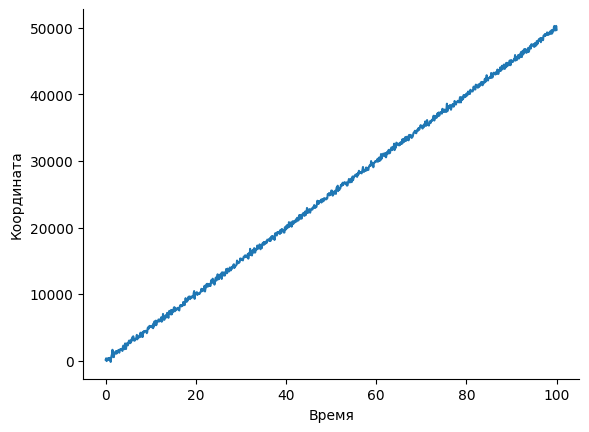

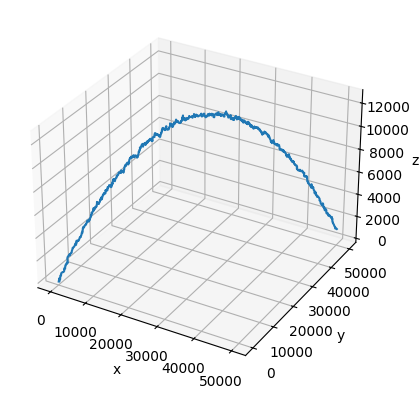

In [143]:
plot_trajectory_1d(t, z_out[:, 0])
plot_trajectory_1d(t, y_n)
plot_trajectory_3d(x_out[:, 0], y_out[:, 0], z_out[:, 0])

# Фильтрация сразу всех координат вместе

In [144]:
import scipy
dt = 0.1
# x = x x_t y y_t z z_t z_tt
x0=np.array([10., 500.,
             10., 500.,
             10., 500., -9.81])

P = np.diag([200**2, 100**2, 200**2, 100**2, 200*2, 100**2, 25])
H = np.array([
    [1., 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0],
])

F = np.array([
    [1., dt, 0, 0, 0, 0, 0],
    [0., 1,  0, 0, 0, 0, 0],
    [0., 0, 1, dt, 0, 0, 0],
    [0., 0, 0, 1, 0, 0, 0],
    [0., 0, 0, 0, 1, dt, (dt**2)/2],
    [0., 0, 0, 0, 0, 1, dt],
    [0., 0, 0, 0, 0, 0, 1]
])

dt = 0.1
Q = scipy.linalg.block_diag(
    [[.25*dt**4, .5*dt**3],
     [ .5*dt**3,    dt**2]],

    [[.25*dt**4, .5*dt**3],
    [ .5*dt**3,    dt**2]],

    [[.25*dt**4, .5*dt**3, .5*dt**2],
    [ .5*dt**3,    dt**2,       dt],
    [ .5*dt**2,       dt,        1]]
)

R = np.diag([250**2, 250**2, 250**2])

KF = KalmanFilter(
    dim_x=7,
    dim_z=3,
    dim_u=0,
    x0=x0,
    P=P, H=H, F=F, B=B, Q=Q, R=R
)

In [145]:
Z =  np.array([x_n, y_n, z_n]).T

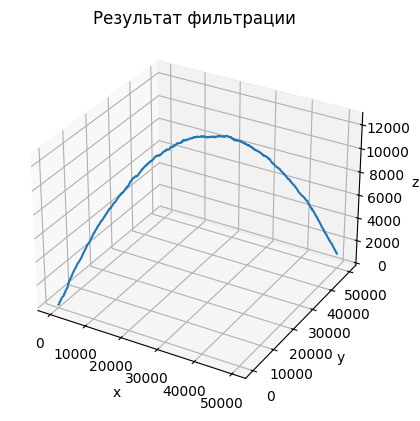

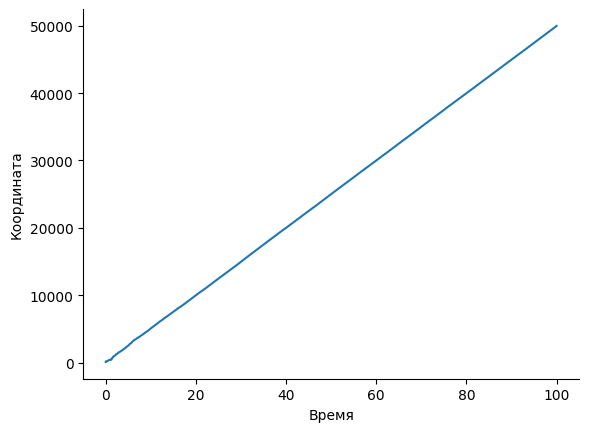

In [146]:
res = KF.batch_filter(Z)
x_KF, y_KF, z_KF = res[:, 0], res[:, 2], res[:, 4]
plot_trajectory_3d(x_KF, y_KF, z_KF, title='Результат фильтрации')
plot_trajectory_1d(t, y_KF)

In [147]:
ys, Ps = KF.evaluate_perfomace(Z)

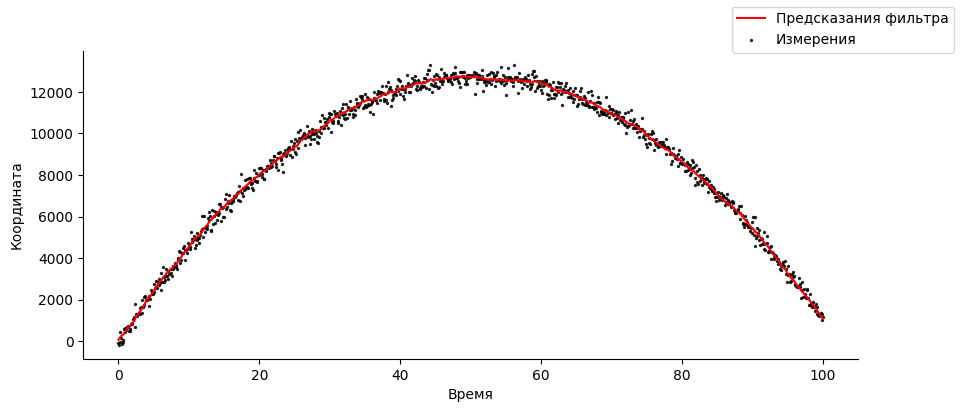

In [150]:
plot_filtering_results_1d(z_KF, Z[:, 2], t)

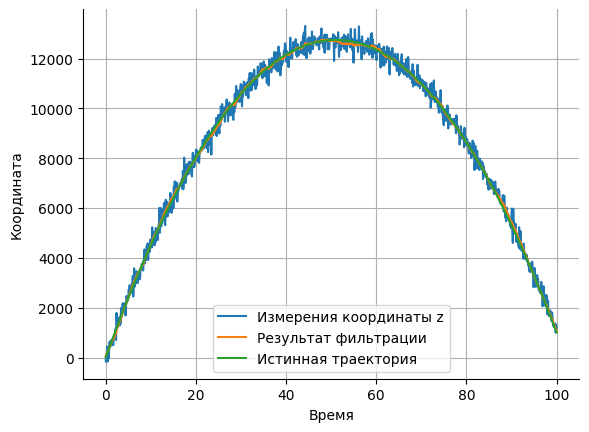

In [156]:
plt.plot(t, Z[:, 2], label='Измерения координаты z')
plt.plot(t, z_KF, label='Результат фильтрации')
plt.plot(t, z, label='Истинная траектория')
plt.grid(which='both')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Время')
plt.ylabel('Координата')
plt.legend()

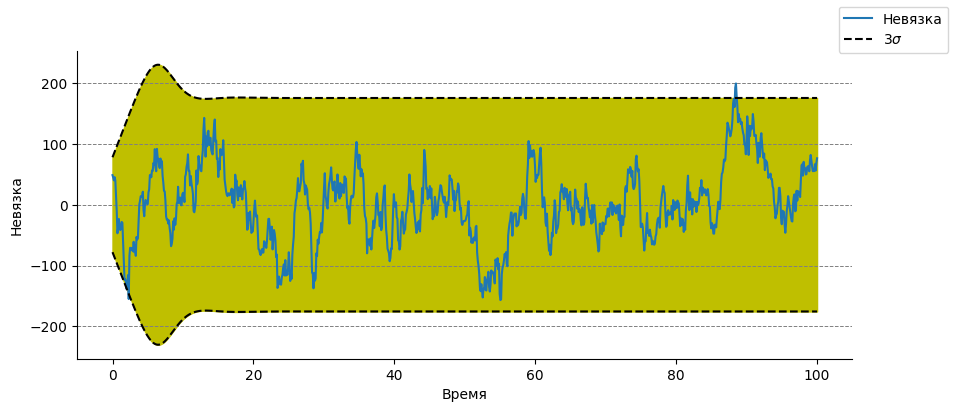

In [152]:
plot_residues_1d(z_KF - z, Ps[:, 6, 6], t, scale=3)